# 1

In [10]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Add path to core/utils
sys.path.append(os.getcwd())

from Core.models import Sequential
from Core.layers import DenseLayer, RoughDenseLayer, RoughIntervalOutputLayer
from Core.activations import TrigonometricActivation, Sigmoid, Linear
from Core.losses import MSELoss, RobustLogCoshLoss, RoughRobustLoss
from Core.optimizers import SGD, EKFOptimizer
from Utils.data_utils import DataHandler

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported for Q3.")

Libraries imported for Q3.


# 2

In [11]:
def plot_prediction(y_true, y_pred, title="Prediction"):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true, label='True Data', color='black', alpha=0.7)
    plt.plot(y_pred, label='Prediction', color='red', linestyle='--')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_noise_comparison(results, title="Noise Robustness Comparison"):
    """
    results: dict {noise_level: {model_name: mse_value}}
    """
    noise_levels = list(results.keys())
    models = list(results[noise_levels[0]].keys())
    
    x = np.arange(len(noise_levels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i, model_name in enumerate(models):
        mses = [results[nl][model_name] for nl in noise_levels]
        ax.bar(x + i*width - width/2, mses, width, label=model_name)
        
    ax.set_xlabel('Noise Level')
    ax.set_ylabel('MSE on Test Data')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{int(n*100)}%" for n in noise_levels])
    ax.legend()
    plt.show()

# 3

In [12]:
# Load Datasets
lorenz_raw = DataHandler.load_data('../HW2/Datasets/regression/Lorenz Dataset.xlsx')
temp_raw = DataHandler.load_data('../HW2/Datasets/regression/Temperature Dataset.xlsx')

# Normalize
lorenz_norm, _ = DataHandler.normalize_data(lorenz_raw)
temp_norm, _ = DataHandler.normalize_data(temp_raw)

# Create Sequences (5 inputs, predict 3rd step ahead)
INPUT_STEPS = 5
PRED_HORIZON = 3

X_lorenz, y_lorenz = DataHandler.create_sequences(lorenz_norm, INPUT_STEPS, PRED_HORIZON)
X_temp, y_temp = DataHandler.create_sequences(temp_norm, INPUT_STEPS, PRED_HORIZON)

# Split
X_train_l, X_test_l, y_train_l, y_test_l = DataHandler.train_test_split(X_lorenz, y_lorenz, train_ratio=0.7, shuffle=False)
X_train_t, X_test_t, y_train_t, y_test_t = DataHandler.train_test_split(X_temp, y_temp, train_ratio=0.7, shuffle=False)

print(f"Lorenz Train: {X_train_l.shape}")
print(f"Temp Train: {X_train_t.shape}")

Lorenz Train: (1395, 5)
Temp Train: (230, 5)


# 4 - a


--- Part A: Trigonometric Network (Sin+Cos) with SGD ---
Starting Training | Mode: SGD | Epochs: 50 | Samples: 1395
Validation enabled | Val Samples: 598


Epoch 1/50: 100%|██████████| 1395/1395 [00:01<00:00, 1092.35sample/s, train_loss=0.00089]


Epoch 1 finished. Train Loss: 0.004187 | Val Loss: 0.018444


Epoch 10/50: 100%|██████████| 1395/1395 [00:01<00:00, 1026.12sample/s, train_loss=0.00072]


Epoch 10 finished. Train Loss: 0.000612 | Val Loss: 0.013223


Epoch 20/50: 100%|██████████| 1395/1395 [00:01<00:00, 1156.00sample/s, train_loss=0.00014]


Epoch 20 finished. Train Loss: 0.000083 | Val Loss: 0.001404


Epoch 30/50: 100%|██████████| 1395/1395 [00:01<00:00, 840.00sample/s, train_loss=0.00007]


Epoch 30 finished. Train Loss: 0.000053 | Val Loss: 0.000365


Epoch 40/50: 100%|██████████| 1395/1395 [00:01<00:00, 822.79sample/s, train_loss=0.00005]


Epoch 40 finished. Train Loss: 0.000041 | Val Loss: 0.000256


Epoch 50/50: 100%|██████████| 1395/1395 [00:01<00:00, 837.18sample/s, train_loss=0.00003]


Epoch 50 finished. Train Loss: 0.000029 | Val Loss: 0.000202
Training Complete. Time: 13.12s


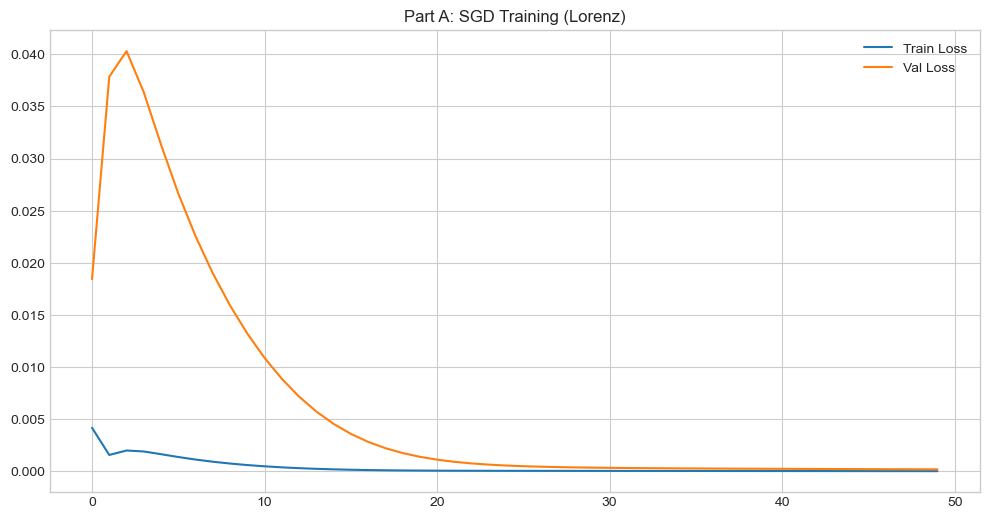

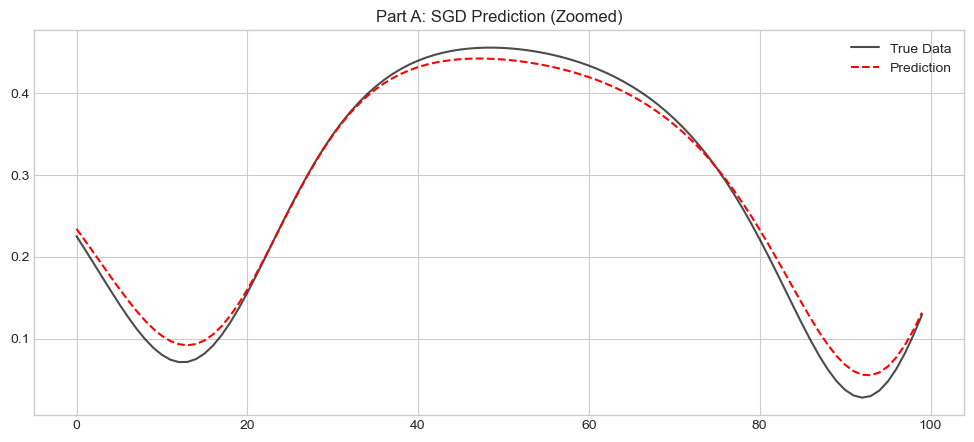

In [13]:
print("\n--- Part A: Trigonometric Network (Sin+Cos) with SGD ---")

# 1. Build Model (Lorenz)
model_sgd = Sequential()
model_sgd.add(DenseLayer(input_dim=5, output_dim=8)) # Hidden Layer
# Mode 'sin_cos' as per Part A formula: sin(ax+b) + cos(ax+b)
model_sgd.add(TrigonometricActivation(input_dim=8, mode='sin_cos')) 
model_sgd.add(DenseLayer(input_dim=8, output_dim=1)) # Output Layer

# 2. Compile
optimizer = SGD(lr=0.01, lr_trig=0.01)
model_sgd.compile(loss=MSELoss(), optimizer=optimizer)

# 3. Train
hist_sgd = model_sgd.fit(X_train_l, y_train_l, 
                         validation_data=(X_test_l, y_test_l),
                         epochs=50, verbose=True, log_freq=10)

# 4. Visualize
plt.plot(hist_sgd['loss'], label='Train Loss')
plt.plot(hist_sgd['val_loss'], label='Val Loss')
plt.title("Part A: SGD Training (Lorenz)")
plt.legend()
plt.show()

preds_sgd = model_sgd.predict(X_test_l)
plot_prediction(y_test_l[:100], preds_sgd[:100].reshape(100, 1), title="Part A: SGD Prediction (Zoomed)")

# 5 - b


--- Part B: Trigonometric Network (Sin only) with EKF ---
EKF Initialized. Total Parameters: 73
Starting Training | Mode: EKF | Epochs: 3 | Samples: 1395
Validation enabled | Val Samples: 598


Epoch 1/3: 100%|██████████| 1395/1395 [00:02<00:00, 592.21sample/s, train_loss=0.00000]


Epoch 1 finished. Train Loss: 0.000154 | Val Loss: 0.000011


Epoch 2/3: 100%|██████████| 1395/1395 [00:02<00:00, 618.95sample/s, train_loss=0.00000]


Epoch 2 finished. Train Loss: 0.000005 | Val Loss: 0.000005


Epoch 3/3: 100%|██████████| 1395/1395 [00:02<00:00, 609.78sample/s, train_loss=0.00000]


Epoch 3 finished. Train Loss: 0.000002 | Val Loss: 0.000004
Training Complete. Time: 6.96s


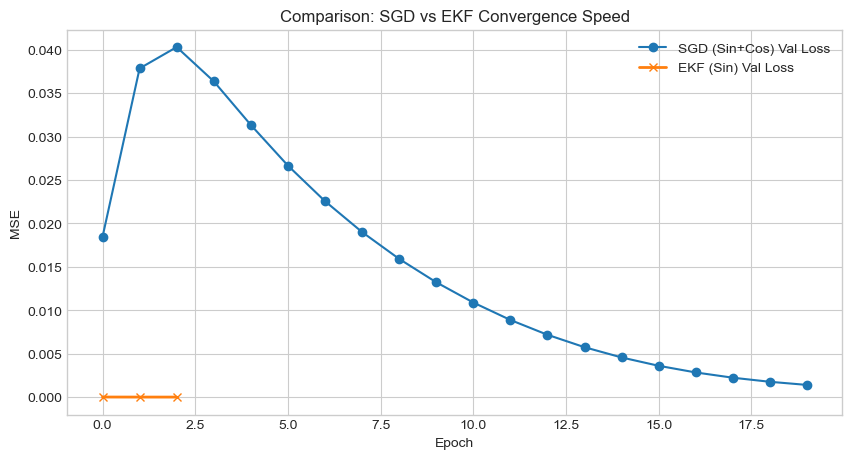

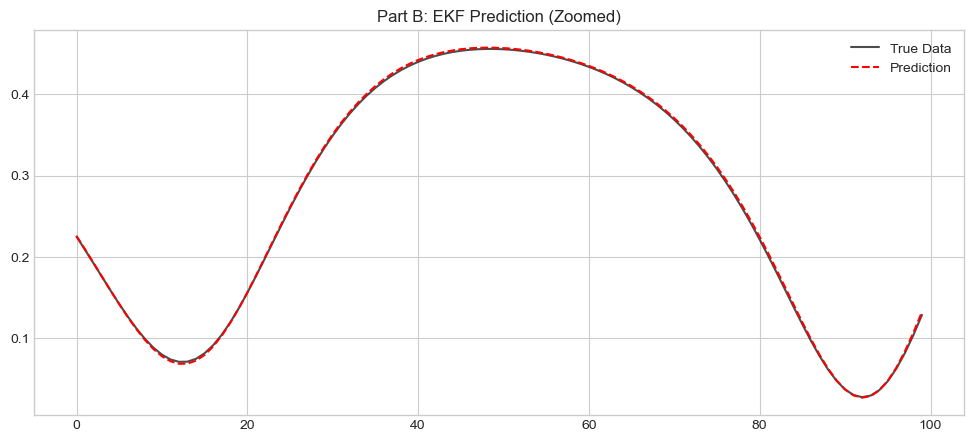

In [14]:
print("\n--- Part B: Trigonometric Network (Sin only) with EKF ---")

# 1. Build Model (Same structure, different activation mode)
model_ekf = Sequential()
model_ekf.add(DenseLayer(input_dim=5, output_dim=8))
# Mode 'sin' as per Part B formula
model_ekf.add(TrigonometricActivation(input_dim=8, mode='sin'))
model_ekf.add(DenseLayer(input_dim=8, output_dim=1))

# 2. Compile with EKF
# EKF converges very fast, usually 5-10 epochs are enough
ekf_opt = EKFOptimizer(layers=model_ekf.layers, P_init=10.0, R_val=0.1, Q_val=1e-5)
model_ekf.compile(loss=MSELoss(), optimizer=ekf_opt)

# 3. Train
hist_ekf = model_ekf.fit(X_train_l, y_train_l, 
                         validation_data=(X_test_l, y_test_l),
                         epochs=3, verbose=True, log_freq=1)

# 4. Comparison Plot (SGD vs EKF)
plt.figure(figsize=(10, 5))
plt.plot(hist_sgd['val_loss'][:20], label='SGD (Sin+Cos) Val Loss', marker='o')
plt.plot(hist_ekf['val_loss'], label='EKF (Sin) Val Loss', marker='x', linewidth=2)
plt.title("Comparison: SGD vs EKF Convergence Speed")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

preds_ekf = model_ekf.predict(X_test_l)
plot_prediction(y_test_l[:100], preds_ekf[:100].reshape(100, 1), title="Part B: EKF Prediction (Zoomed)")

# 6 - c


--- Part C: Noise Robustness Comparison ---

Processing Noise Level: 10.0%
Starting Training | Mode: SGD | Epochs: 50 | Samples: 1395
Validation enabled | Val Samples: 598
Training Complete. Time: 4.32s
Starting Training | Mode: SGD | Epochs: 50 | Samples: 1395
Validation enabled | Val Samples: 598
Training Complete. Time: 4.29s
  > Trig MSE: 0.00504 | Sigmoid MSE: 0.00444


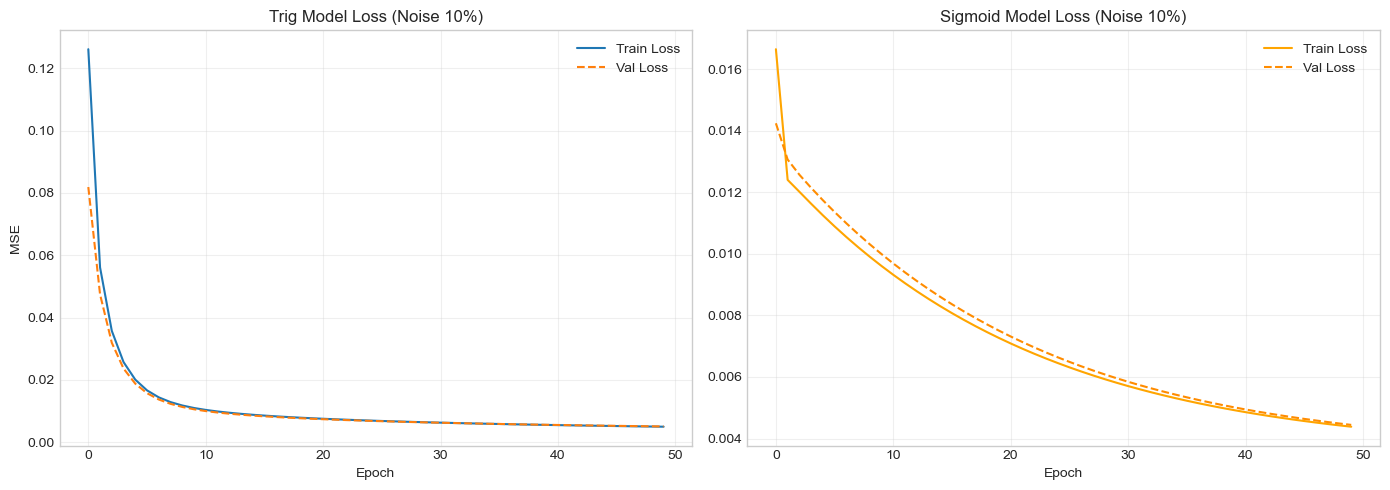


Processing Noise Level: 50.0%
Starting Training | Mode: SGD | Epochs: 50 | Samples: 1395
Validation enabled | Val Samples: 598
Training Complete. Time: 4.27s
Starting Training | Mode: SGD | Epochs: 50 | Samples: 1395
Validation enabled | Val Samples: 598
Training Complete. Time: 4.30s
  > Trig MSE: 0.01398 | Sigmoid MSE: 0.01466


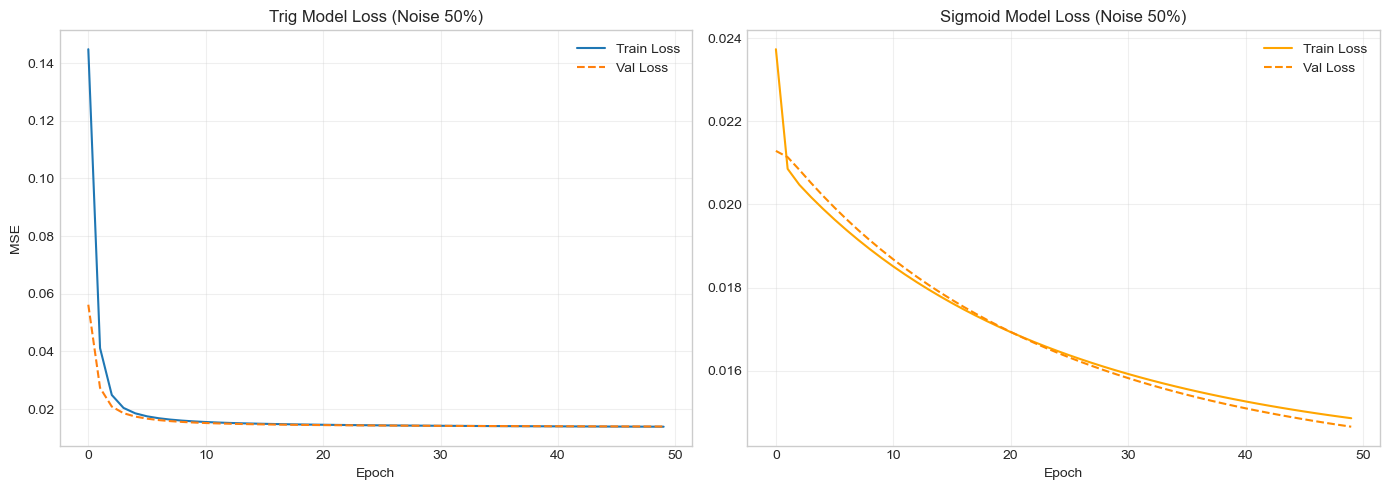


Processing Noise Level: 100.0%
Starting Training | Mode: SGD | Epochs: 50 | Samples: 1395
Validation enabled | Val Samples: 598
Training Complete. Time: 4.39s
Starting Training | Mode: SGD | Epochs: 50 | Samples: 1395
Validation enabled | Val Samples: 598
Training Complete. Time: 4.54s
  > Trig MSE: 0.02378 | Sigmoid MSE: 0.02399


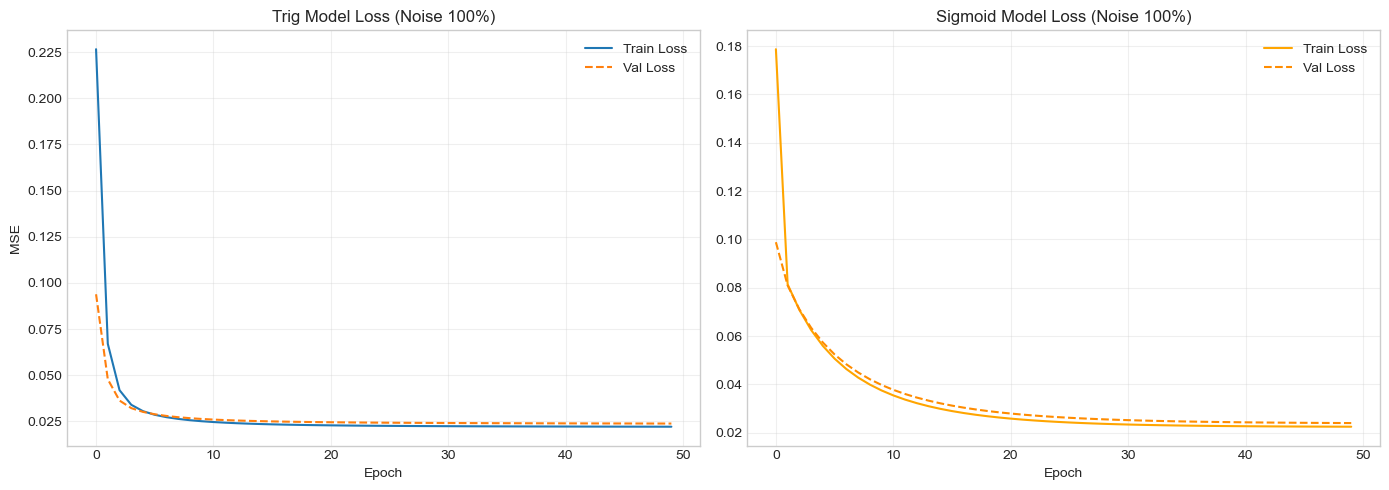

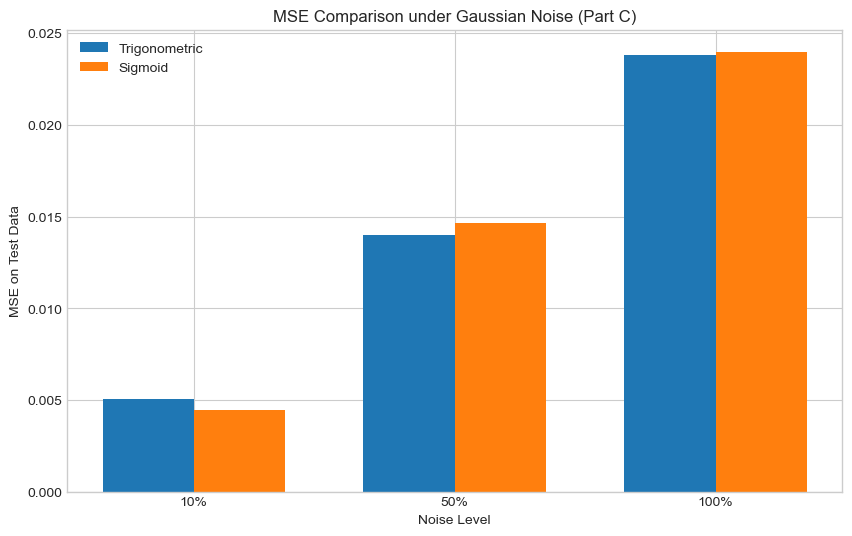

In [15]:
# 6 - c
print("\n--- Part C: Noise Robustness Comparison ---")

def plot_model_losses(hist_trig, hist_sig, noise_level):
    """Helper to plot losses for both models side-by-side"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot Trigonometric Losses
    ax1.plot(hist_trig['loss'], label='Train Loss')
    # Note: We didn't pass validation_data to fit() in the loop above to save time/code complexity,
    # so 'val_loss' might be empty or not what we want.
    # To fix this, we should pass validation_data to fit().
    if 'val_loss' in hist_trig and len(hist_trig['val_loss']) > 0:
        ax1.plot(hist_trig['val_loss'], label='Val Loss', linestyle='--')
    ax1.set_title(f"Trig Model Loss (Noise {int(noise_level*100)}%)")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("MSE")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot Sigmoid Losses
    ax2.plot(hist_sig['loss'], label='Train Loss', color='orange')
    if 'val_loss' in hist_sig and len(hist_sig['val_loss']) > 0:
        ax2.plot(hist_sig['val_loss'], label='Val Loss', linestyle='--', color='darkorange')
    ax2.set_title(f"Sigmoid Model Loss (Noise {int(noise_level*100)}%)")
    ax2.set_xlabel("Epoch")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

noise_levels = [0.10, 0.50, 1.00] # 10%, 50%, 100%
results_c = {}

for nl in noise_levels:
    print(f"\nProcessing Noise Level: {nl*100}%")
    results_c[nl] = {}
    
    # 1. Add Noise
    X_train_noisy = DataHandler.add_noise(X_train_l.copy(), nl)
    X_test_noisy = DataHandler.add_noise(X_test_l.copy(), nl)
    
    # --- Model 1: Trigonometric (Sin+Cos) ---
    model_trig = Sequential()
    model_trig.add(DenseLayer(5, 8))
    model_trig.add(TrigonometricActivation(8, mode='sin_cos'))
    model_trig.add(DenseLayer(8, 1))
    model_trig.compile(MSELoss(), SGD(lr=0.0005))
    
    # Pass validation_data to capture val_loss for plotting
    hist_trig = model_trig.fit(X_train_noisy, y_train_l, 
                               validation_data=(X_test_noisy, y_test_l),
                               epochs=50, verbose=False)
    
    # Use the final validation loss as the metric
    mse_trig = hist_trig['val_loss'][-1]
    results_c[nl]['Trigonometric'] = mse_trig
    
    # --- Model 2: Sigmoid ---
    model_sig = Sequential()
    model_sig.add(DenseLayer(5, 8))
    model_sig.add(Sigmoid())
    model_sig.add(DenseLayer(8, 1))
    model_sig.compile(MSELoss(), SGD(lr=0.0005)) 
    
    hist_sig = model_sig.fit(X_train_noisy, y_train_l, 
                             validation_data=(X_test_noisy, y_test_l),
                             epochs=50, verbose=False)
                             
    mse_sig = hist_sig['val_loss'][-1]
    results_c[nl]['Sigmoid'] = mse_sig
    
    print(f"  > Trig MSE: {mse_trig:.5f} | Sigmoid MSE: {mse_sig:.5f}")
    
    # Plot losses for this noise level
    plot_model_losses(hist_trig, hist_sig, nl)

# Plot Comparison Bar Chart
plot_noise_comparison(results_c, title="MSE Comparison under Gaussian Noise (Part C)")


--- Part D: Improved Rough Robust Network (10% Noise) ---
Objective: Compare 'Rough Robust' innovation vs 'Trigonometric' baseline.
Training Proposed Rough Robust Model...
Starting Training | Mode: SGD | Epochs: 50 | Samples: 1395
Validation enabled | Val Samples: 598
Training Complete. Time: 6.60s
Training Benchmark Trigonometric Model (for comparison)...
Starting Training | Mode: SGD | Epochs: 50 | Samples: 1395
Validation enabled | Val Samples: 598
Training Complete. Time: 4.71s


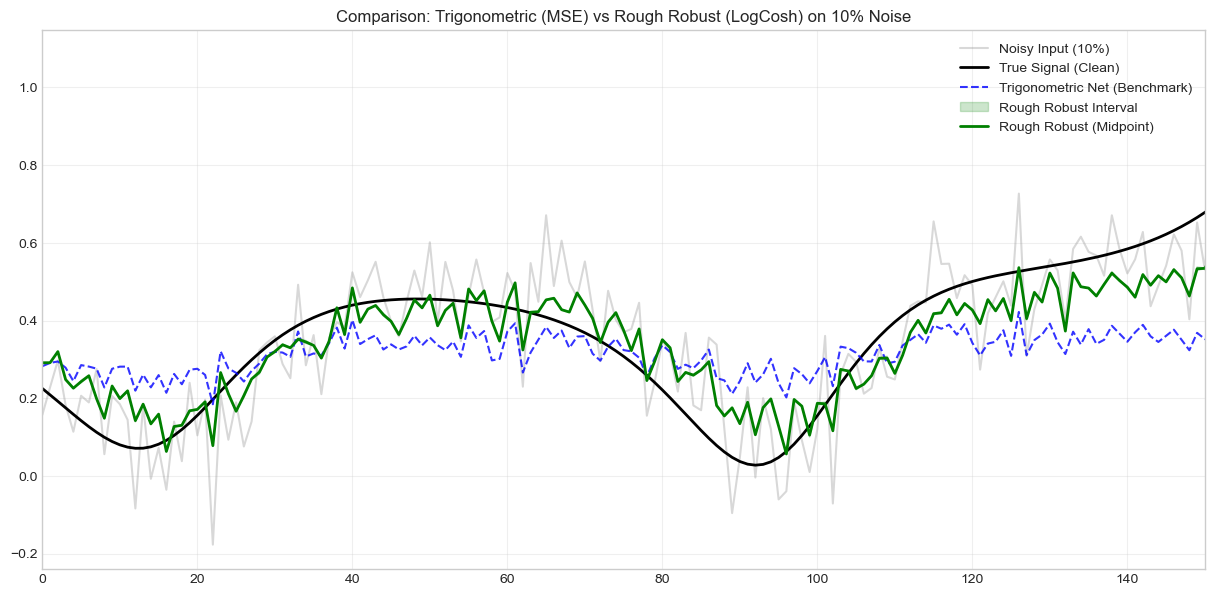

In [16]:
print("\n--- Part D: Improved Rough Robust Network (10% Noise) ---")
print("Objective: Compare 'Rough Robust' innovation vs 'Trigonometric' baseline.")

# 1. Setup Data with 10% Noise
noise_level = 0.1  # Changed to 10%
X_train_noisy = DataHandler.add_noise(X_train_l.copy(), noise_level)
X_test_noisy = DataHandler.add_noise(X_test_l.copy(), noise_level)

# --- Model 1: The Proposed Innovation (Rough Network + Robust Loss) ---
print("Training Proposed Rough Robust Model...")
model_robust = Sequential()
model_robust.add(DenseLayer(input_dim=5, output_dim=10)) 
model_robust.add(RoughIntervalOutputLayer(input_dim=10, output_dim=1)) 

# Using RoughRobustLoss (LogCosh on intervals)
model_robust.compile(loss=RoughRobustLoss(), optimizer=SGD(lr=0.005))

hist_robust = model_robust.fit(X_train_noisy, y_train_l, 
                               validation_data=(X_test_noisy, y_test_l),
                               epochs=50, verbose=False)

# --- Model 2: The Benchmark from Part C (Trigonometric Network) ---
print("Training Benchmark Trigonometric Model (for comparison)...")
model_trig = Sequential()
model_trig.add(DenseLayer(input_dim=5, output_dim=8))
model_trig.add(TrigonometricActivation(input_dim=8, mode='sin_cos'))
model_trig.add(DenseLayer(input_dim=8, output_dim=1))

# Using Standard MSE Loss
model_trig.compile(loss=MSELoss(), optimizer=SGD(lr=0.01))

hist_trig = model_trig.fit(X_train_noisy, y_train_l, 
                           validation_data=(X_test_noisy, y_test_l),
                           epochs=50, verbose=False)

# --- Visualization Function ---
def plot_comparison_final(model_rough, model_trig, X_noisy, y_clean, title):
    # 1. Get Predictions for Rough Model
    y_L, y_U, preds_rough_mid = [], [], []
    layer_rough = model_rough.layers[-1]
    
    # Reset states manually just in case
    for i in range(len(X_noisy)):
        _ = model_rough.forward(X_noisy[i])
        l_val = layer_rough.net_L.item()
        u_val = layer_rough.net_U.item()
        y_L.append(l_val)
        y_U.append(u_val)
        preds_rough_mid.append((l_val + u_val) / 2)
        
    # 2. Get Predictions for Trigonometric Model
    preds_trig = model_trig.predict(X_noisy).flatten()
    
    # 3. Plotting
    plt.figure(figsize=(15, 7))
    
    # A) Plot Noisy Input (Optional, taking just the last step of sequence to visualize noise)
    # X_noisy is (N, 5), we can plot the last feature as a proxy for the noisy signal
    plt.plot(X_noisy[:, -1], color='gray', alpha=0.3, label='Noisy Input (10%)')
    
    # B) Plot Clean Signal
    plt.plot(y_clean, color='black', linewidth=2, label='True Signal (Clean)')
    
    # C) Plot Trigonometric Prediction
    plt.plot(preds_trig, color='blue', linestyle='--', alpha=0.8, label='Trigonometric Net (Benchmark)')
    
    # D) Plot Rough Robust Prediction
    plt.fill_between(range(len(y_L)), y_L, y_U, color='green', alpha=0.2, label='Rough Robust Interval')
    plt.plot(preds_rough_mid, color='green', linewidth=2, label='Rough Robust (Midpoint)')
    
    plt.title(title)
    plt.legend()
    plt.xlim(0, 150) # Zoom in to see details
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualize Comparison
plot_comparison_final(model_robust, model_trig, X_test_noisy, y_test_l, 
                      title="Comparison: Trigonometric (MSE) vs Rough Robust (LogCosh) on 10% Noise")

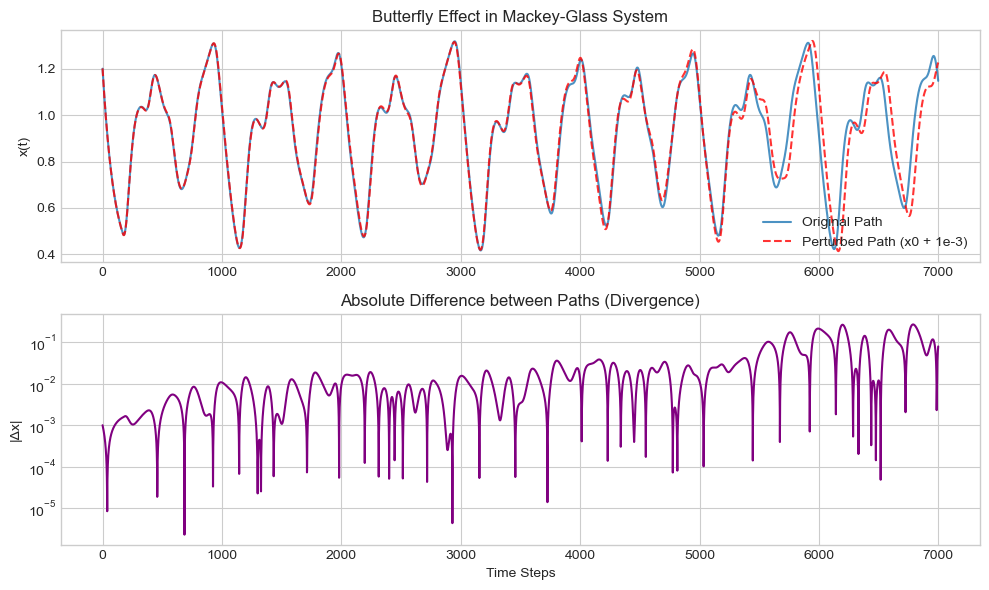

In [17]:
# Parameters
n_steps = 7000
tau = 17
x0 = 1.2
epsilon = 1e-3 # Tiny perturbation for Butterfly Effect

# Generate two trajectories
path1 = DataHandler.generate_mackey_glass(n_steps, tau, x0)
path2 = DataHandler.generate_mackey_glass(n_steps, tau, x0 + epsilon)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot both trajectories
plt.subplot(2, 1, 1)
plt.plot(path1, label='Original Path', alpha=0.8)
plt.plot(path2, label='Perturbed Path (x0 + 1e-3)', linestyle='--', color='red', alpha=0.8)
plt.title('Butterfly Effect in Mackey-Glass System')
plt.ylabel('x(t)')
plt.legend()
plt.grid(True)

# Plot the difference (Divergence)
plt.subplot(2, 1, 2)
plt.plot(np.abs(path1 - path2), color='purple')
plt.title('Absolute Difference between Paths (Divergence)')
plt.xlabel('Time Steps')
plt.ylabel('|Δx|')
plt.yscale('log') # Log scale helps see the exponential growth of error
plt.grid(True)

plt.tight_layout()
plt.show()

# 9 - Part F (Final) - Updated


--- Part F: Robust Cost Function vs Butterfly Effect ---
Objective: Prove robustness of LogCosh loss against MSE on chaotic noisy data.
Preparing Data with 10% Noise...

Training Model 1: Standard MLP + MSE Loss...
Starting Training | Mode: SGD | Epochs: 200 | Samples: 1395
Validation enabled | Val Samples: 598
Training Complete. Time: 21.41s


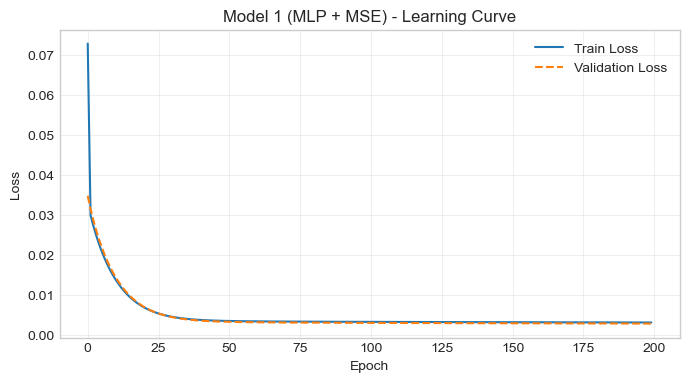

In [32]:

print("\n" + "="*60)
print("--- Part F: Robust Cost Function vs Butterfly Effect ---")
print("Objective: Prove robustness of LogCosh loss against MSE on chaotic noisy data.")
print("="*60)

# 1. Setup Data: 10% Noise (as requested)
noise_level_f = 0.10 
print(f"Preparing Data with {int(noise_level_f*100)}% Noise...")

# Add noise to inputs only (Targets remain clean to teach signal recovery)
X_train_F = DataHandler.add_noise(X_train_l.copy(), noise_level_f)
X_test_F = DataHandler.add_noise(X_test_l.copy(), noise_level_f)

# Helper function to plot loss curves
def plot_individual_loss(history, model_name):
    plt.figure(figsize=(8, 4))
    plt.plot(history['loss'], label='Train Loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation Loss', linestyle='--')
    plt.title(f"{model_name} - Learning Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- Model 1: Standard MLP with MSE (Vulnerable) ---
print("\nTraining Model 1: Standard MLP + MSE Loss...")
model_mse = Sequential()
model_mse.add(DenseLayer(input_dim=5, output_dim=10))
model_mse.add(Sigmoid())
model_mse.add(DenseLayer(input_dim=10, output_dim=1))

model_mse.compile(loss=MSELoss(), optimizer=SGD(lr=0.001))

hist_mse = model_mse.fit(X_train_F, y_train_l, 
                         validation_data=(X_test_F, y_test_l),
                         epochs=200, verbose=False)

plot_individual_loss(hist_mse, "Model 1 (MLP + MSE)")

Training Model 2: Standard MLP + Robust LogCosh Loss...
Starting Training | Mode: SGD | Epochs: 200 | Samples: 1395
Validation enabled | Val Samples: 598
Training Complete. Time: 18.24s


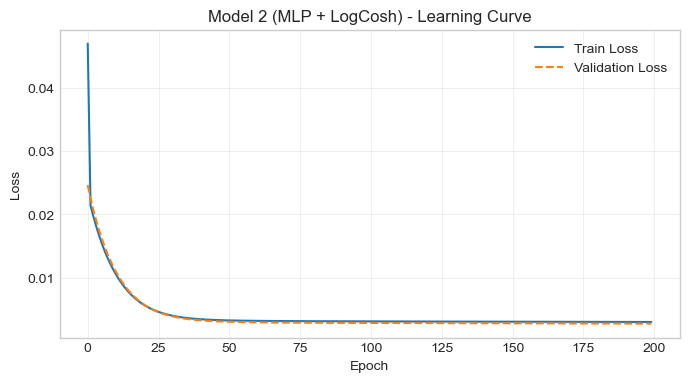

In [33]:
# --- Model 2: Standard MLP with Robust LogCosh (Resistant) ---
print("Training Model 2: Standard MLP + Robust LogCosh Loss...")
model_robust = Sequential()
model_robust.add(DenseLayer(input_dim=5, output_dim=10))
model_robust.add(Sigmoid())
model_robust.add(DenseLayer(input_dim=10, output_dim=1))

model_robust.compile(loss=RobustLogCoshLoss(), optimizer=SGD(lr=0.001))

hist_robust = model_robust.fit(X_train_F, y_train_l, 
                               validation_data=(X_test_F, y_test_l),
                               epochs=200, verbose=False)

plot_individual_loss(hist_robust, "Model 2 (MLP + LogCosh)")

Training Model 3: Trigonometric Net + Robust LogCosh Loss...
Starting Training | Mode: SGD | Epochs: 200 | Samples: 1395
Validation enabled | Val Samples: 598
Training Complete. Time: 19.45s


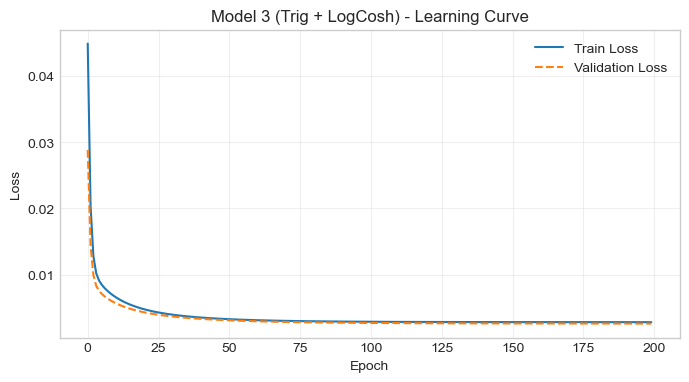

In [34]:
# --- Model 3: Trigonometric Network with Robust LogCosh (Best) ---
print("Training Model 3: Trigonometric Net + Robust LogCosh Loss...")
model_trig_robust = Sequential()
model_trig_robust.add(DenseLayer(input_dim=5, output_dim=8))
model_trig_robust.add(TrigonometricActivation(input_dim=8, mode='sin_cos'))
model_trig_robust.add(DenseLayer(input_dim=8, output_dim=1))

model_trig_robust.compile(loss=RobustLogCoshLoss(), optimizer=SGD(lr=0.0005))

hist_trig_robust = model_trig_robust.fit(X_train_F, y_train_l, 
                                         validation_data=(X_test_F, y_test_l),
                                         epochs=200, verbose=False)

plot_individual_loss(hist_trig_robust, "Model 3 (Trig + LogCosh)")


Final Test Results (Clean Target Recovery):
1. MLP + MSE Loss:          0.10326
2. MLP + Robust Loss:       0.10389
3. Trig Net + Robust Loss:  0.10317


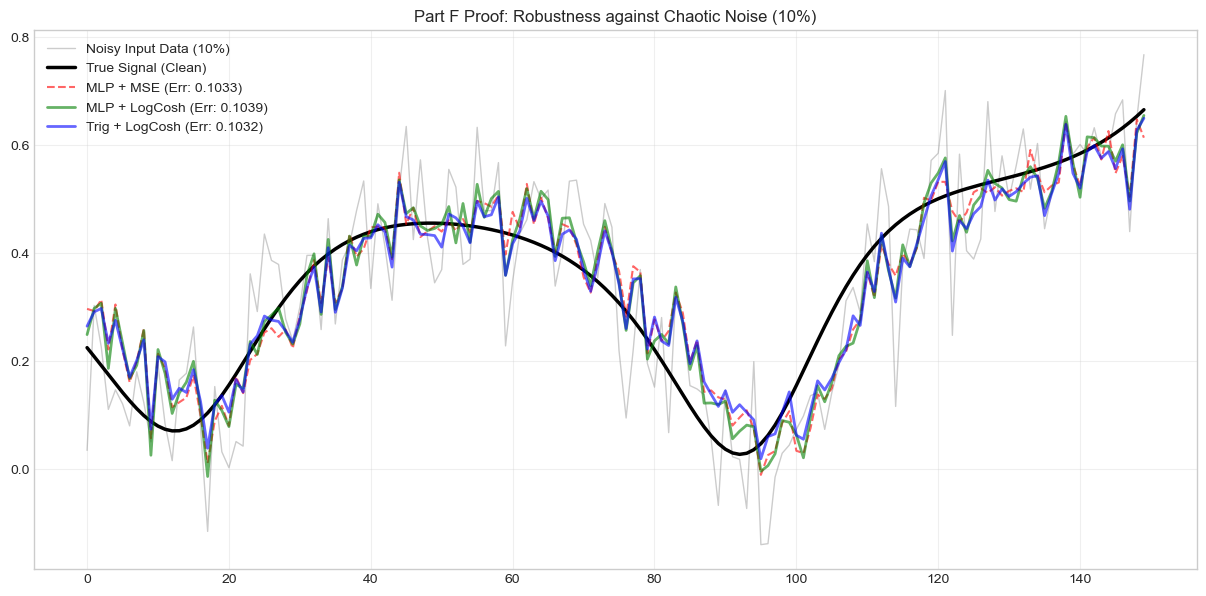

In [35]:
# --- Evaluation & Visualization ---

# 1. Compare Final Validation Loss (Calculated via MSE for fairness)
def get_test_mse(model, X, y):
    preds = model.predict(X)
    return np.mean((preds - y) ** 2)

mse_1 = get_test_mse(model_mse, X_test_F, y_test_l)
mse_2 = get_test_mse(model_robust, X_test_F, y_test_l)
mse_3 = get_test_mse(model_trig_robust, X_test_F, y_test_l)

print(f"\nFinal Test Results (Clean Target Recovery):")
print(f"1. MLP + MSE Loss:          {mse_1:.5f}")
print(f"2. MLP + Robust Loss:       {mse_2:.5f}")
print(f"3. Trig Net + Robust Loss:  {mse_3:.5f}")

# 2. Visual Proof: Robustness against Chaotic Noise
preds_1 = model_mse.predict(X_test_F)
preds_2 = model_robust.predict(X_test_F)
preds_3 = model_trig_robust.predict(X_test_F)

plt.figure(figsize=(15, 7))

# A) Plot Noisy Input (The raw data the model sees)
# We plot the last feature of the input sequence to represent the noisy trajectory
plt.plot(X_test_F[:150, -1], color='gray', alpha=0.4, linewidth=1, label='Noisy Input Data (10%)')

# B) Plot Clean Signal (The Goal)
plt.plot(y_test_l[:150].reshape(-1, 1), color='black', linewidth=2.5, label='True Signal (Clean)')

# C) Plot MSE Model Prediction
plt.plot(preds_1[:150].reshape(-1, 1), color='red', linestyle='--', alpha=0.6, label=f'MLP + MSE (Err: {mse_1:.4f})')

# D) Plot Robust Model Prediction
plt.plot(preds_2[:150].reshape(-1, 1), color='green', linewidth=2, alpha=0.6, label=f'MLP + LogCosh (Err: {mse_2:.4f})')

# E) Plot Trigonometric Robust Model Prediction
plt.plot(preds_3[:150].reshape(-1, 1), color='blue', linewidth=2, alpha=0.6, label=f'Trig + LogCosh (Err: {mse_3:.4f})')

plt.title("Part F Proof: Robustness against Chaotic Noise (10%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()